<a href="https://colab.research.google.com/github/mebalint/hgt_m_csapat/blob/main/hgt_m_csapat_football_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Labdarúgómérkőzések eredményének prediktálása gépi tanulással**




### Csomagok importálása

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import KernelPCA

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, LassoLars, Ridge, BayesianRidge, SGDRegressor, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

# to supress warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

from sklearn import metrics
from seaborn import heatmap

### Adatbetöltés
A https://figshare.com/collections/Soccer_match_event_dataset/4415000 címen nyilvánosan elérhető adatból nyertük ki saját számításaink alapján a számunkra fontos mennyiségeket. Az adat az európai top 5 futball bajnokság (angol, német, olasz, spanyol, francia) 2017/18-as szezonjának összes meccséről szól, egy adott meccsen minden labdás eseményről van feljegyzés (pl. passzok, lövések, gólok). Ezen események alapján az egyszerű meccsstatisztikákat (pl. kapura lövés, szabadrúgások) és néhány hálózattudományi mértéket (pl. betweenness centrality) határoztunk meg. Ezenfelül a kezdeti adattáblánál minden meccshez hozzávettük még a labdabirtoklást és egy fogadóiroda által kínált győzelmi odds-ot mind a hazai, mind a vendég csapat esetében. 

A kezdeti adattábla így néz ki az adatok beszerzése és előkészítése után (amit a hgt_m_csapat_football_data notebookban csináltunk, de mivel nagyon komplex feladat volt, így ezt a részt kihagytuk a bemutatásra szánt részből):

In [5]:
matches=pd.read_csv('https://raw.githubusercontent.com/mebalint/hgt/main/matches_final.csv', sep='\t', index_col=0)
matches=matches.drop(columns=['competitionId', 'roundId', 'match_id', 'draw_odds'])
matches

,home,away,home_goal,away_goal,gameweek,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,Lazio,Inter,2,3,38,10,3,302,492,228,...,0.40,0.60,22.000,37.545,2,2,0.027,0.019,0.072,0.032
1,Sassuolo,AS Roma,0,1,38,5,9,337,500,206,...,0.42,0.58,23.182,36.909,2,2,0.024,0.011,0.066,0.032
2,Cagliari,Atalanta,1,0,38,5,11,232,587,235,...,0.31,0.69,15.545,45.909,2,2,0.037,0.019,0.111,0.027
3,Chievo,Benevento,1,0,38,2,4,198,721,221,...,0.24,0.76,12.818,55.364,2,2,0.042,0.025,0.144,0.021
4,Udinese,Bologna,1,0,38,10,2,327,518,207,...,0.41,0.59,24.636,39.636,3,2,0.033,0.019,0.064,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,Tottenham,Swansea,0,0,5,11,1,753,220,177,...,0.75,0.25,60.636,13.909,2,3,0.013,0.037,0.018,0.130
1822,Tottenham,Burnley,1,1,3,10,7,573,276,179,...,0.66,0.34,44.909,18.545,2,2,0.016,0.026,0.026,0.086
1823,Tottenham,Chelsea,1,2,2,14,3,569,249,223,...,0.68,0.32,43.545,17.091,2,2,0.009,0.030,0.025,0.098
1824,Sevilla,Alaves,1,0,38,8,3,601,361,205,...,0.61,0.39,48.091,25.364,2,3,0.013,0.030,0.024,0.057


Tehát 1826 mérkőzést vizsgálunk. Minden statisztikai mérték esetében van egy hazai és egy vendég oszlopunk, ami az adott hazai- vagy vendégcsapat az adott meccsen történt eseményekből kiszámolt értékeit mutatja. A "gameweek" oszlop azt jelzi, hogy hányadik fordulóban játszották le a mérkőzést.

In [ ]:
matches.columns

Index(['home', 'away', 'home_goal', 'away_goal', 'gameweek', 'home_corner',
       'away_corner', 'home_pass', 'away_pass', 'home_duel', 'away_duel',
       'home_foul', 'away_foul', 'home_save attempt', 'away_save attempt',
       'home_shot', 'away_shot', 'home_shot_on_target', 'away_shot_on_target',
       'home_free_kick', 'away_free_kick', 'home_odds', 'away_odds',
       'home_possession', 'away_possession', 'home_degree', 'away_degree',
       'home_diameter', 'away_diameter', 'home_bet_cent', 'away_bet_cent',
       'home_entropy', 'away_entropy'],
      dtype='object')

A következő blokk az adatok skálázásához kell, de enélkül jobb eredményt mutat a modellünk.

In [ ]:
"""
columns_to_scale=['home_corner', 'away_corner', 'home_pass', 'away_pass', 'home_duel', 'away_duel', 
                  'home_foul', 'away_foul', 'home_save attempt', 'away_save attempt', 'home_shot', 
                  'away_shot', 'home_shot_on_target', 'away_shot_on_target', 'home_free_kick', 
                 'away_free_kick', 'home_degree', 'away_degree', 'home_diameter', 'away_diameter']
scaler = StandardScaler() #MinMaxScaler()
matches[columns_to_scale]=scaler.fit_transform(matches[columns_to_scale])
"""

In [8]:
# itt csak akkor van változás a matches adattáblában, ha skálázunk
matches

,home,away,home_goal,away_goal,gameweek,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,Lazio,Inter,2,3,38,10,3,302,492,228,...,0.40,0.60,22.000,37.545,2,2,0.027,0.019,0.072,0.032
1,Sassuolo,AS Roma,0,1,38,5,9,337,500,206,...,0.42,0.58,23.182,36.909,2,2,0.024,0.011,0.066,0.032
2,Cagliari,Atalanta,1,0,38,5,11,232,587,235,...,0.31,0.69,15.545,45.909,2,2,0.037,0.019,0.111,0.027
3,Chievo,Benevento,1,0,38,2,4,198,721,221,...,0.24,0.76,12.818,55.364,2,2,0.042,0.025,0.144,0.021
4,Udinese,Bologna,1,0,38,10,2,327,518,207,...,0.41,0.59,24.636,39.636,3,2,0.033,0.019,0.064,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,Tottenham,Swansea,0,0,5,11,1,753,220,177,...,0.75,0.25,60.636,13.909,2,3,0.013,0.037,0.018,0.130
1822,Tottenham,Burnley,1,1,3,10,7,573,276,179,...,0.66,0.34,44.909,18.545,2,2,0.016,0.026,0.026,0.086
1823,Tottenham,Chelsea,1,2,2,14,3,569,249,223,...,0.68,0.32,43.545,17.091,2,2,0.009,0.030,0.025,0.098
1824,Sevilla,Alaves,1,0,38,8,3,601,361,205,...,0.61,0.39,48.091,25.364,2,3,0.013,0.030,0.024,0.057


### Korrelációszámítás

Ebben a blokkban a változók közti korrelációt szeretnénk megnézni. Ha a korreláció abszolút értéke meghaladja a 0.6-ot, akkor C-vel vagy N-el töltjük ki a mezőt annak függvényében, hogy a két változó azonos vagy különböző 'típussal' (home vagy away) rendelkezik.

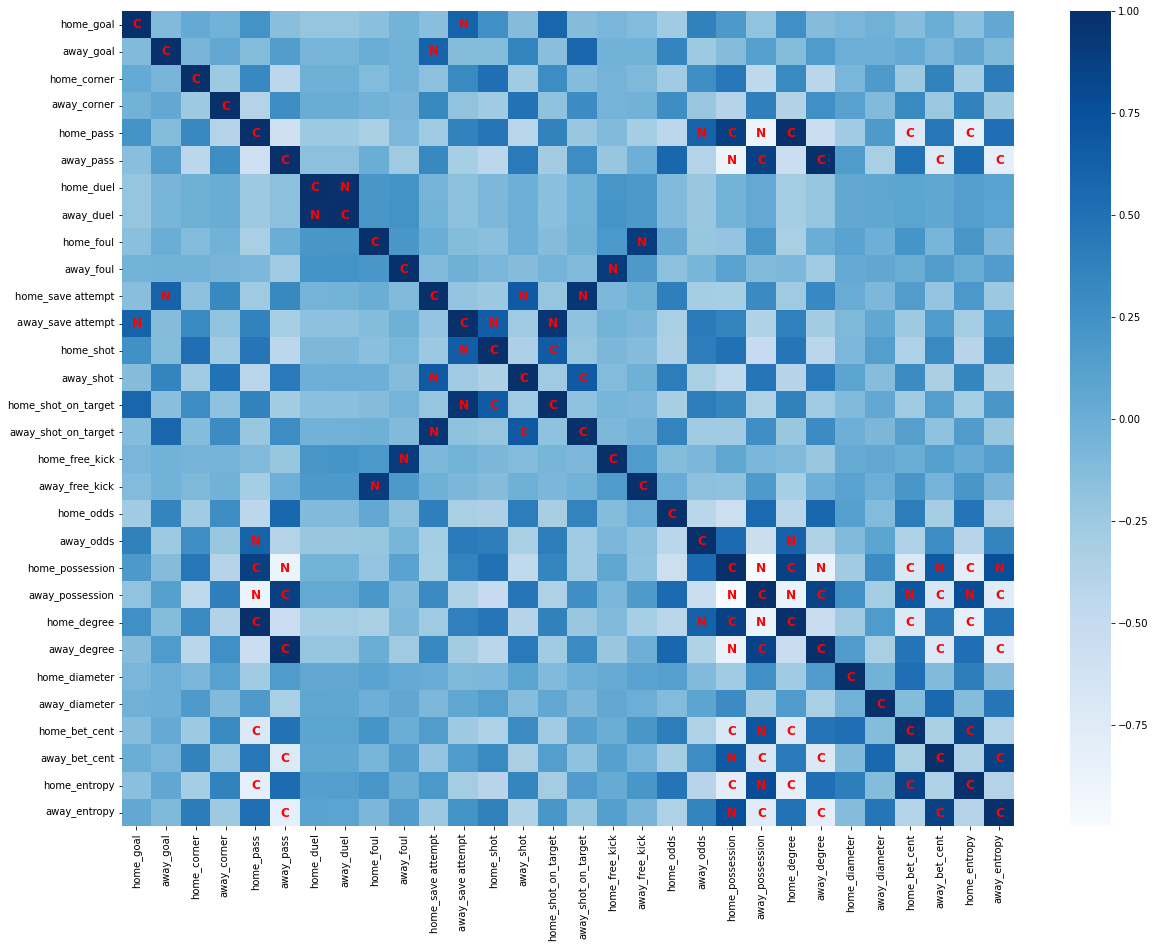

In [9]:
# korreláció kiszámítása
corr = np.array(matches.drop(columns=['home', 'away', 'gameweek']).corr())

# a korrelációmátrix feltöltése C-vel, ha a mező értéke nagyobb, mint 0.6 
annot_labels = np.empty_like(corr, dtype=str)
annot_mask = abs(corr) > 0.6
annot_labels[annot_mask] = 'C'

# ha 0.6 feletti a korreláció és nem egyezik meg a két változó típusa,
# akkor a C-t N-re cseréljük (vagyis egy home és egy away változó
# korrelációjánál most már N lesz)
for row_index in range(annot_labels.shape[0]):
  for column_index in range(annot_labels.shape[1]):
    if annot_labels[row_index][column_index]=='C' and (row_index+column_index)%2==1:
        annot_labels[row_index][column_index]='N'

# sorok és oszlopok elnevezése az ábrához
columnnames=matches.drop(columns=['home', 'away', 'gameweek']).columns

# az ábra elkészítése
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=annot_labels, annot_kws={'fontsize': 12, 'fontweight': 'bold', 'color':'red'}, cmap="Blues", fmt='', xticklabels=columnnames, yticklabels=columnnames, ax=ax)

Nézzük meg például, hogy a home_pass változó melyik home típusú változókkal korrelál:

In [11]:
annot_labels[4]=='C'

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
       False,  True, False])

Az utolsó előtti cellában például True van, tehát a home_entropy-val korrellál a home_pass.

### Adattáblák készítése a meccsstatisztikák tanításához

A mérkőzések eredményét két lépésben fogjuk prediktálni:


1.   egy adott mérkőzésre meccsstatisztikákat prediktálunk az utolsó 10 mérkőzésen látott meccsstatisztika alapján (minden statisztika prediktálásánál azokat a változókat használjuk, amelyek erősen (0.6 feletti) korrelálnak),
2.   majd ezekből a meccsstatisztikákból fogunk prediktálni a mérkőzés eredményére (azaz erre is tanítunk egy modellt).

Így vannak meccsstatisztikára tanuló modelljeink, illetve végeredményre tanuló modellünk is.

Tegyük fel, hogy holnap van egy mérkőzés, amelynek a végeredményét szeretnénk előrejelezni. Ekkor vesszük mindkét csapatnál az utolsó 10 meccsen elért statisztikát, és prediktálunk meccsstatisztikákat a holnap találkozóra. Majd ebből végeredményt prediktálunk az ehhez tartozó modellünkkel.



A következő függvény a statisztika típusát megcseréli. Hogy miért van erre szükség, arra a későbbiekben fény derül.

In [12]:
replace_dict={}
for column in matches.columns:
  if 'home' in column:
    column_r=column.replace('home', 'away')
  else:
    column_r=column.replace('away', 'home')
  replace_dict[column]=column_r


In [13]:
replace_dict['home_corner']

'away_corner'

Az adattáblában szeretnénk, hogy a "gameweek" oszlop a harmadik legyen, ezért ezt egy függvénnyel oldjuk meg:

In [14]:
def swapPositions(list, pos1, pos2):

    #ez szükséges hogy a gameweek a harmadik helyett az ötödik oszlopban szerepeljen

    list[pos1], list[pos2] = list[pos2], list[pos1]
    return list

A következő adattáblában minden meccs kétszer szerepel az eredeti adattáblához tartozó meccsekhez képest. De két azonos sor nincsen benne, ugyanis az eredeti adattáblához hozzácsatoljuk a "megfordított" adattáblát, amit úgy kapunk, hogy minden meccsnél megfordítjuk a home és away oszlopokat (a home és away statisztikákat is). Erre azért van szükség, hogy minden csapat minden meccsen hazaiként is szerepeljen az adatunkban, mégpedig a gameweek változó szerint növekvő sorrendben. Ennek köszönhetően pedig, ha egy adott csapat utolsó 10 meccsstatisztikáját szeretnénk kinyerni az adatból, akkor egyszerűen csak az adott oszlopot kell néznünk.

In [15]:
reversed_matches=matches.copy()
reversed_matches[list(replace_dict.values())]=reversed_matches[list(replace_dict.keys())]
matches_stat=pd.concat([reversed_matches, matches]).sort_values(by=['home', 'gameweek'])
matches_stat=matches_stat.reindex(columns=swapPositions(swapPositions(list(matches.columns), 3, 4), 2, 3))
matches_stat=matches_stat.reset_index(drop=True)
matches_stat.head(11)

,home,away,gameweek,home_goal,away_goal,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Crotone,1,3,0,9,2,679,152,165,...,0.79,0.21,54.273,8.636,3,4,0.025,0.086,0.022,0.278
1,AC Milan,Cagliari,2,2,1,2,6,403,406,176,...,0.49,0.51,30.636,31.545,2,2,0.024,0.022,0.045,0.042
2,AC Milan,Lazio,3,1,4,5,3,618,411,183,...,0.60,0.40,49.727,30.273,2,2,0.014,0.029,0.023,0.051
3,AC Milan,Udinese,4,2,1,10,3,539,380,210,...,0.58,0.42,40.636,27.091,2,2,0.018,0.032,0.030,0.055
4,AC Milan,Spal,5,2,0,9,8,505,354,201,...,0.58,0.42,38.909,24.636,2,2,0.024,0.026,0.034,0.058
5,AC Milan,Sampdoria,6,0,2,4,7,421,357,216,...,0.54,0.46,31.273,23.917,3,3,0.030,0.035,0.047,0.065
6,AC Milan,AS Roma,7,0,2,5,5,407,501,187,...,0.46,0.54,29.727,39.000,2,2,0.029,0.017,0.049,0.031
7,AC Milan,Inter,8,2,3,7,2,448,281,229,...,0.59,0.41,34.273,19.545,2,2,0.021,0.034,0.039,0.086
8,AC Milan,Genoa,9,0,0,5,3,413,384,249,...,0.52,0.48,31.636,28.818,2,2,0.023,0.025,0.043,0.049
9,AC Milan,Chievo,10,4,1,1,1,601,416,197,...,0.58,0.42,48.000,31.273,2,2,0.022,0.018,0.027,0.041


Nézzük meg, hogyan szeretnénk meghatározni a 11. fordulóban az AC Milan - Juventus mérkőzés home_pass statisztikáját (jelen esetben 507):

vesszük azokat a statisztikákat amivel erősen korrelál, és az első 10 forduló statisztikáiból elkészítjük az adattáblát. Az 507 lesz a magyarázott változó a tanulásnál, az adattáblából készített egydimenziós, "flatten-elt" vektor pedig a magyarázó változóhoz tartozó értékeket tartalmazza.

In [20]:
ar_c=[True, False, True]+list(annot_labels[4]=='C')
ar_n=[False, True, True]+list(annot_labels[4]=='N')
matches_stat.iloc[:10, ar_c].merge(matches_stat.iloc[:10,ar_n], how='inner', on='gameweek')

,home,gameweek,home_pass,home_possession,home_degree,home_bet_cent,home_entropy,away,away_odds,away_possession
0,AC Milan,1,679,0.79,54.273,0.025,0.022,Crotone,7.07,0.21
1,AC Milan,2,403,0.49,30.636,0.024,0.045,Cagliari,10.20,0.51
2,AC Milan,3,618,0.60,49.727,0.014,0.023,Lazio,2.37,0.40
3,AC Milan,4,539,0.58,40.636,0.018,0.030,Udinese,8.64,0.42
4,AC Milan,5,505,0.58,38.909,0.024,0.034,Spal,12.94,0.42
5,AC Milan,6,421,0.54,31.273,0.030,0.047,Sampdoria,3.70,0.46
6,AC Milan,7,407,0.46,29.727,0.029,0.049,AS Roma,2.76,0.54
7,AC Milan,8,448,0.59,34.273,0.021,0.039,Inter,2.21,0.41
8,AC Milan,9,413,0.52,31.636,0.023,0.043,Genoa,5.79,0.48
9,AC Milan,10,601,0.58,48.000,0.022,0.027,Chievo,3.45,0.42


Ez viszont még nem jó, ugyanis a 11. fordulóban az AC Milan ellenfele a Juventus, és a kapott adattáblában az away oszlopok értékei nem a Juventus-hoz tartoznak.

Ezért az away oszlopokhoz a Juventus utolsó 10 meccses statisztikáit kell beraknunk.

In [28]:
ar_c=[True, False, True]+list(annot_labels[4]=='C')
ar_n=[False, True, True]+list(annot_labels[4]=='N')
opponent_df=matches_stat[matches_stat['home']=='Juventus']
opponent_df[list(replace_dict.values())]=opponent_df[list(replace_dict.keys())]
matches_stat.iloc[:10, ar_c].merge(opponent_df.iloc[:,ar_n], how='inner', on='gameweek')

,home,gameweek,home_pass,home_possession,home_degree,home_bet_cent,home_entropy,away,away_odds,away_possession
0,AC Milan,1,679,0.79,54.273,0.025,0.022,Juventus,1.15,0.62
1,AC Milan,2,403,0.49,30.636,0.024,0.045,Juventus,1.44,0.57
2,AC Milan,3,618,0.60,49.727,0.014,0.023,Juventus,1.24,0.58
3,AC Milan,4,539,0.58,40.636,0.018,0.030,Juventus,1.47,0.62
4,AC Milan,5,505,0.58,38.909,0.024,0.034,Juventus,1.38,0.60
5,AC Milan,6,421,0.54,31.273,0.030,0.047,Juventus,1.40,0.66
6,AC Milan,7,407,0.46,29.727,0.029,0.049,Juventus,1.81,0.58
7,AC Milan,8,448,0.59,34.273,0.021,0.039,Juventus,1.57,0.60
8,AC Milan,9,413,0.52,31.636,0.023,0.043,Juventus,1.40,0.44
9,AC Milan,10,601,0.58,48.000,0.022,0.027,Juventus,1.12,0.69


Végülis AC Milan esetén a home pass statisztika tanítóaadatának előkészítéséhez a következő adattáblát használjuk fel az 507-re való tanításhoz:

In [30]:
ar_c=[True, False, True]+list(annot_labels[4]=='C')
ar_n=[False, True, True]+list(annot_labels[4]=='N')
opponent_df=matches_stat[matches_stat['home']=='Juventus']
opponent_df[list(replace_dict.values())]=opponent_df[list(replace_dict.keys())]
matches_stat.iloc[:10, ar_c].merge(opponent_df.iloc[:,ar_n], how='inner', on='gameweek').drop(columns=['home', 'gameweek', 'away'])

,home_pass,home_possession,home_degree,home_bet_cent,home_entropy,away_odds,away_possession
0,679,0.79,54.273,0.025,0.022,1.15,0.62
1,403,0.49,30.636,0.024,0.045,1.44,0.57
2,618,0.60,49.727,0.014,0.023,1.24,0.58
3,539,0.58,40.636,0.018,0.030,1.47,0.62
4,505,0.58,38.909,0.024,0.034,1.38,0.60
5,421,0.54,31.273,0.030,0.047,1.40,0.66
6,407,0.46,29.727,0.029,0.049,1.81,0.58
7,448,0.59,34.273,0.021,0.039,1.57,0.60
8,413,0.52,31.636,0.023,0.043,1.40,0.44
9,601,0.58,48.000,0.022,0.027,1.12,0.69


A következő listát azért csináljuk, mert az oszlopokat szeretnénk egy számmal jelölni

In [32]:
stats=list(matches.drop(columns=['home', 'away', 'gameweek']).columns)
stats[3]

'away_corner'

A bajnokságok első 32 fordulóján tanítjuk a modellünket, és az utolsó 6 fordulón (a német Bundesliga esetében az utolsó 2-n) pedig teszteljük.

A következő függvény az előző példához hasonlóan egy adott statisztikához készíti el a tanítóadatot.

In [33]:
def stat_generator_train(stat_number, stats_loc=stats, matches_stat_loc=matches_stat):
  stat_name=stats_loc[stat_number]
  matches_stat=matches_stat_loc.reset_index(drop=True)
  X_stat=[]
  y_stat=[]
  ar_c=[True, False, True]+list(annot_labels[stat_number]=='C')
  ar_n=[False, True, True]+list(annot_labels[stat_number]=='N')
  matches_check=[]
  for index, row in matches_stat.iterrows():
    opponent=row['away']
    gameweek=row['gameweek']
    if row['gameweek']>10 and row['gameweek']<33:
      matches_check.append(row)
      opponent_df=matches_stat[matches_stat['home']==opponent]
      opponent_df[list(replace_dict.values())]=opponent_df[list(replace_dict.keys())]
      X_stat.append(np.array(matches_stat.iloc[index-10:index, ar_c].merge(opponent_df.iloc[:,ar_n], how='inner', on='gameweek').drop(columns=['home', 'away', 'gameweek'])).reshape(1,-1).flatten())
      y_stat.append(row[stat_name])
  return X_stat, y_stat, matches_check

Pl. az away_corner meccstatisztika esetén ez így néz ki:

In [34]:
X_stat, y_stat, matches_check = stat_generator_train(3)

In [35]:
X_stat[0], y_stat[0]

(array([2, 6, 3, 3, 8, 7, 5, 2, 3, 1]), 6)

Tehát a [2, 6, 3, 3, 8, 7, 5, 2, 3, 1] vektorral szeretnénk becsülni a 6-ot.

In [36]:
len(X_stat), len(y_stat)

(2156, 2156)

Ez az adattábla az ellenőrzéshez kell majd, ugyanis ezekre a meccsekre tanulunk rá a mérkőzésstatisztikák tanításánál.

In [37]:
pd.DataFrame(matches_check).reset_index(drop=True)

,home,away,gameweek,home_goal,away_goal,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Juventus,11,0,2,5,6,507,436,207,...,0.54,0.46,38.455,32.364,2,2,0.021,0.020,0.033,0.041
1,AC Milan,Sassuolo,12,2,0,10,7,440,342,230,...,0.55,0.45,31.182,21.909,2,2,0.016,0.023,0.040,0.068
2,AC Milan,Napoli,13,1,2,1,3,608,501,176,...,0.55,0.45,46.273,38.909,2,2,0.014,0.023,0.026,0.033
3,AC Milan,Torino,14,0,0,5,4,410,332,297,...,0.54,0.46,30.273,23.455,2,2,0.022,0.024,0.046,0.063
4,AC Milan,Benevento,15,2,2,3,4,420,394,218,...,0.52,0.48,32.000,29.636,2,2,0.029,0.016,0.046,0.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,Wolfsburg,Hertha Berlin,28,0,0,5,4,429,474,265,...,0.48,0.52,31.000,34.909,2,2,0.012,0.018,0.039,0.037
2152,Wolfsburg,Freiburg,29,2,0,3,9,290,427,247,...,0.40,0.60,18.727,30.545,2,2,0.028,0.018,0.085,0.043
2153,Wolfsburg,Augsburg,30,0,0,7,5,481,266,209,...,0.61,0.39,37.273,17.727,2,2,0.014,0.026,0.030,0.090
2154,Wolfsburg,B. Monchengladbach,31,0,3,5,8,355,537,188,...,0.42,0.58,25.545,42.273,2,2,0.025,0.017,0.059,0.029


Ugyanez a függvény teszt esetben:

In [38]:
def stat_generator_test(stat_number, stats_loc=stats, matches_stat_loc=matches_stat):
  stat_name=stats_loc[stat_number]
  matches_stat=matches_stat_loc.reset_index(drop=True)
  X_stat_test=[]
  y_stat_test=[]
  ar_c=[True, False, True]+list(annot_labels[stat_number]=='C')
  ar_n=[False, True, True]+list(annot_labels[stat_number]=='N')
  matches_check_test=[]
  for index, row in matches_stat.iterrows():
    opponent=row['away']
    gameweek=row['gameweek']
    if row['gameweek']>32:
      matches_check_test.append(row)
      opponent_df=matches_stat[matches_stat['home']==opponent]
      opponent_df[list(replace_dict.values())]=opponent_df[list(replace_dict.keys())]
      X_stat_test.append(np.array(matches_stat.iloc[index-10:index, ar_c].merge(opponent_df.iloc[:,ar_n], how='inner', on='gameweek').drop(columns=['home', 'away', 'gameweek'])).reshape(1,-1).flatten())
      y_stat_test.append(row[stat_name])
  return X_stat_test, y_stat_test, matches_check_test

In [39]:
X_stat_test, y_stat_test, matches_check_test = stat_generator_test(3)

In [41]:
X_stat_test[0], y_stat_test[0]

(array([5, 3, 1, 9, 4, 3, 1, 2, 3, 8]), 6)

In [ ]:
len(X_stat_test), len(y_stat_test)

(516, 516)

Az adattábla azokat a meccseket tartalmazza, amelyeket tesztelni szeretnénk, hogy mennyire tanult jól rá az algoritmus.

In [42]:
pd.DataFrame(matches_check_test).reset_index(drop=True)

,home,away,gameweek,home_goal,away_goal,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Torino,33,1,1,6,6,469,437,193,...,0.53,0.47,37.364,30.000,2,2,0.020,0.032,0.035,0.050
1,AC Milan,Benevento,34,0,1,4,1,563,329,235,...,0.63,0.37,43.364,23.636,2,2,0.024,0.018,0.029,0.058
2,AC Milan,Bologna,35,2,1,1,7,492,423,171,...,0.54,0.46,38.727,31.455,2,2,0.025,0.015,0.034,0.040
3,AC Milan,Verona,36,4,1,5,4,639,387,179,...,0.61,0.39,51.818,30.636,2,2,0.014,0.016,0.022,0.041
4,AC Milan,Atalanta,37,1,1,8,3,419,427,208,...,0.51,0.49,32.000,31.909,2,2,0.015,0.026,0.040,0.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,West Ham,Manchester City,36,1,4,0,7,260,860,181,...,0.26,0.74,17.182,70.636,2,2,0.038,0.012,0.101,0.015
512,West Ham,Leicester,37,2,0,3,8,354,409,233,...,0.47,0.53,24.909,29.182,3,2,0.030,0.017,0.062,0.044
513,West Ham,Everton,38,3,1,6,6,448,341,184,...,0.57,0.43,34.636,25.273,2,2,0.019,0.025,0.037,0.057
514,Wolfsburg,RB Leipzig,33,1,4,5,2,387,345,216,...,0.52,0.48,27.091,23.727,2,2,0.024,0.028,0.051,0.061


### A meccsstatisztikákra való tanításhoz szükséges dolgok:
A stat_fit_model függvény során egy adott statisztikára (stat_number) tanulunk rá egy regressziós vagy osztályozó algoritmussal (clf). A függvény megkapja még a listát, amelyben a stat_number alapján tudni fogjuk a statisztika nevét, és még a matches_stat adattáblát is, ugyanis az pedig a kis adattáblák kialakításához kell, amivel vektorokat tudunk csinálni. 
A stat_rmse függvény az előző mintájára kiszámítja az rmse értéket.

In [43]:
def stat_fit_model(stat_number,  clf, stats_locc=stats, matches_stat_locc=matches_stat):
  X_stat, y_stat, _ = stat_generator_train(stat_number, stats_loc=stats_locc, matches_stat_loc=matches_stat_locc)
  clf.fit(X_stat, y_stat)
  return clf

In [44]:
def stat_rmse(stat_number,  clf_loc, stats_loc=stats, matches_stat_loc=matches_stat):
  clf=stat_fit_model(stat_number,  clf_loc, stats_locc=stats_loc, matches_stat_locc=matches_stat_loc)
  X_stat_test, y_stat_test, _ = stat_generator_test(stat_number)
  y_pred=clf.predict(X_stat_test)
  return metrics.mean_squared_error(y_stat_test, y_pred, squared=False)

Ez a lista azért kell, mert ezekre a statisztikákra tanulunk rá.

In [45]:
stat_list=list(range(30))
stat_list.pop(18)
stat_list.pop(18)
stat_list.pop(0)
stat_list.pop(0)

1

Az egyes statisztikáknak a RMSE értéke:

In [ ]:
for stat_number in stat_list:
  stat_rmse_=stat_rmse(stat_number, GradientBoostingRegressor(loss = 'ls', max_depth = 10))
  print(stats[stat_number]+': '+str(stat_rmse_))

home_corner: 2.9164866133828027
away_corner: 2.8811845812618255
home_pass: 94.00838024736096
away_pass: 97.54308657425466
home_duel: 33.54863250018733
away_duel: 34.40869746250295
home_foul: 4.236910850798123
away_foul: 4.202244773268712
home_save attempt: 2.5888290019388878
away_save attempt: 2.6178452788740443
home_shot: 4.650439763150862
away_shot: 4.5829406411942735
home_shot_on_target: 2.5038245213333052
away_shot_on_target: 2.5508932351594167
home_free_kick: 4.192041997274293
away_free_kick: 4.088737925547975
home_possession: 0.07515924782257011
away_possession: 0.08110082978212868
home_degree: 8.301564019433881
away_degree: 8.504477049457577
home_diameter: 0.34600487511818734
away_diameter: 0.34182661207784565
home_bet_cent: 0.007279167455279467
away_bet_cent: 0.007688016370166623
home_entropy: 0.02544220407270717
away_entropy: 0.027235536316080007


### Tanítás az eredményekre:

Az eredményekhez való tanításnál ugyanazzal az adattal dolgozunk, mint a meccsstatisztikákra való tanításnál, de itt nem kell más alakra hoznunk az eredeti matches adattáblát, vagyis nem kell a duplikálás:

In [46]:
train_df=matches[matches['gameweek']<=32]
test_df=matches[matches['gameweek']>32]

In [47]:
train_df

,home,away,home_goal,away_goal,gameweek,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
60,Lazio,AS Roma,0,0,32,7,2,300,436,263,...,0.43,0.57,19.091,31.182,2,2,0.032,0.019,0.088,0.042
61,Juventus,Sampdoria,3,0,32,6,8,577,562,149,...,0.50,0.50,45.364,44.000,2,3,0.016,0.021,0.028,0.028
62,Sassuolo,Benevento,2,2,32,7,1,327,564,240,...,0.39,0.61,22.273,43.455,3,2,0.029,0.015,0.066,0.026
63,Bologna,Verona,2,0,32,3,4,354,324,257,...,0.52,0.48,24.909,22.455,3,2,0.026,0.026,0.057,0.068
64,AC Milan,Napoli,0,0,32,11,8,528,688,156,...,0.44,0.56,41.727,54.909,2,2,0.024,0.021,0.032,0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,Tottenham,Bournemouth,1,0,8,9,5,667,225,205,...,0.72,0.28,53.091,15.455,2,3,0.017,0.041,0.021,0.118
1821,Tottenham,Swansea,0,0,5,11,1,753,220,177,...,0.75,0.25,60.636,13.909,2,3,0.013,0.037,0.018,0.130
1822,Tottenham,Burnley,1,1,3,10,7,573,276,179,...,0.66,0.34,44.909,18.545,2,2,0.016,0.026,0.026,0.086
1823,Tottenham,Chelsea,1,2,2,14,3,569,249,223,...,0.68,0.32,43.545,17.091,2,2,0.009,0.030,0.025,0.098


In [48]:
test_df

,home,away,home_goal,away_goal,gameweek,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,Lazio,Inter,2,3,38,10,3,302,492,228,...,0.40,0.60,22.000,37.545,2,2,0.027,0.019,0.072,0.032
1,Sassuolo,AS Roma,0,1,38,5,9,337,500,206,...,0.42,0.58,23.182,36.909,2,2,0.024,0.011,0.066,0.032
2,Cagliari,Atalanta,1,0,38,5,11,232,587,235,...,0.31,0.69,15.545,45.909,2,2,0.037,0.019,0.111,0.027
3,Chievo,Benevento,1,0,38,2,4,198,721,221,...,0.24,0.76,12.818,55.364,2,2,0.042,0.025,0.144,0.021
4,Udinese,Bologna,1,0,38,10,2,327,518,207,...,0.41,0.59,24.636,39.636,3,2,0.033,0.019,0.064,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,Dep. La Coruna,Sevilla,0,0,33,7,9,318,552,244,...,0.38,0.62,22.273,43.909,2,2,0.026,0.015,0.067,0.027
1804,Tottenham,Leicester,5,4,38,4,4,441,246,227,...,0.64,0.36,33.364,17.000,2,3,0.019,0.037,0.038,0.100
1806,Tottenham,Watford,2,0,36,4,0,548,322,209,...,0.61,0.39,41.545,22.545,2,2,0.016,0.026,0.029,0.067
1807,Tottenham,Manchester City,1,3,34,5,7,443,502,190,...,0.48,0.52,31.636,39.364,2,2,0.023,0.010,0.043,0.028


In [49]:
# tanítás az eredményre
X = train_df.drop(columns = ['home', 'away', 'home_goal', 'away_goal', 'gameweek']).values
y_home = train_df['home_goal'].values
y_away = train_df['away_goal'].values
clf_home = GradientBoostingRegressor(loss = 'ls', max_depth = 10)
clf_away = GradientBoostingRegressor(loss = 'ls', max_depth = 10)
clf_home.fit(X, y_home)
clf_away.fit(X, y_away)

GradientBoostingRegressor(loss='ls', max_depth=10)

In [51]:
y_home_true=test_df['home_goal'].values
y_home_pred=clf_home.predict(test_df.iloc[:,5:].values)
metrics.mean_squared_error(y_home_true, np.round(y_home_pred), squared=False)

1.1479675332361716

In [52]:
y_away_true=test_df['away_goal'].values
y_away_pred=clf_away.predict(test_df.iloc[:,5:].values)
metrics.mean_squared_error(y_away_true, np.round(y_away_pred), squared=False)

0.9764672918705589

In [50]:
home_goal_mean=np.mean(np.array(test_df['home_goal']))
away_goal_mean=np.mean(np.array(test_df['away_goal']))

In [53]:
metrics.mean_squared_error(y_home_true, [home_goal_mean for i in y_home_true], squared=False)

1.389355128762146

1.38> 1.14, tehát jobb a modellünk, mintha az átlagot tippelnénk minden esetben a hazai gólszámra.



In [54]:
metrics.mean_squared_error(y_away_true, [away_goal_mean for i in y_away_true], squared=False)

1.1173014267494932

1.17> 0.97, tehát jobb a modellünk, mintha az átlagot tippelnénk minden esetben a vendég gólszámra.

A következő függvény a hazai gólszámból és vendég gólszámból meghatározza, hogy mi lett a mérkőzés kimenetele

In [55]:
def result(home_column, away_column):
  home_minus_away=np.array(home_column-away_column)
  results = np.empty_like(home_minus_away, dtype=str)
  home_win = home_minus_away > 0
  results[home_win] = '1'
  away_win = home_minus_away < 0
  results[away_win] = '2'
  draw = home_minus_away == 0
  results[draw] = 'X'
  return results

Az eredmények tévesztési mátrixa az eredménytanítás után (tehát itt olyan, mintha a holnapi meccs statisztikáit előre tudnánk és az alapján jóslunk az eredményre):

In [57]:
cf_matrix=metrics.confusion_matrix(result(test_df.iloc[:,2],test_df.iloc[:,3]), result(np.round(y_home_pred), np.round(y_away_pred)), labels=['1', 'X', '2'])
cf_matrix

array([[88, 21,  9],
       [12, 26, 19],
       [13, 23, 47]])

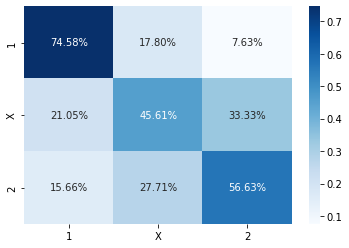

In [58]:
# soronként, azaz az eredeti osztályozás szerint
sns.heatmap(cf_matrix/np.repeat(np.sum(cf_matrix, axis=1), 3).reshape(3, 3), annot=True, fmt='.2%', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])

Tehát a valójában 1-es győzelmet hozó mérkőzést közel 75 százalékban 1-esnek tippeljük mi is. A 2-es esetben ez 57%, döntetlennél: 46%.

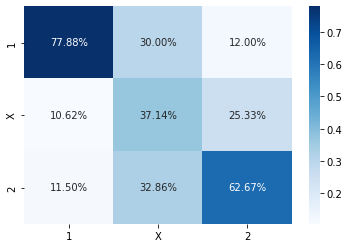

In [59]:
# oszloponként, azaz a predikció szerint
sns.heatmap(cf_matrix/np.repeat([np.sum(cf_matrix, axis=0)], 3, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])

Vagyis amit mi 1-esnek tippeltünk kb. 78 százalékban 1-es lett tényleg. 2-esnél: 63%, X-nél: 37%.

In [60]:
np.sum(np.diagonal(cf_matrix))/np.sum(cf_matrix)

0.624031007751938

A meccsek 62 százalékát eltaláltuk végkimenetel tekintetében.

### Eredmények a statisztikák, majd abból az eredmények tanulása után

Ebben a blokkban már a teljes prediktálás megtörténik, vagyis először előrejelezzük a holnapi meccs statisztikáit, majd abból az eredményeket is.

A következő függvény meghatározza a tesztmeccsekre a stat_number statisztikát a clf_loc algoritmussal.

In [61]:
def stat_results(stat_number,  clf_loc, stats_loc=stats, matches_stat_loc=matches_stat):
  clf=stat_fit_model(stat_number,  clf_loc, stats_locc=stats_loc, matches_stat_locc=matches_stat_loc)
  X_stat_test, y_stat_test, _ = stat_generator_test(stat_number)
  y_pred=clf.predict(X_stat_test)
  return y_pred

Itt megtanítjuk az összes statisztikára tanuló algoritmust:

In [62]:
list_of_stats=[]
list_of_stats_names=[]
for stat_number in stat_list:
  list_of_stats.append(list(stat_results(stat_number, GradientBoostingRegressor(loss = 'ls', max_depth = 10))))
  list_of_stats_names.append(stats[stat_number])

Az egyes meccsekre a következő statisztikákat kaptuk:

In [63]:
stat_df = pd.DataFrame(list(zip(*list_of_stats)), columns=list_of_stats_names)
stat_df

,home_corner,away_corner,home_pass,away_pass,home_duel,away_duel,home_foul,away_foul,home_save attempt,away_save attempt,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,5.419086,4.416657,546.226471,391.637931,218.688895,202.015594,11.498418,15.474752,3.090698,5.583136,...,0.596530,0.439735,37.987417,29.781714,2.079023,2.106886,0.016944,0.021652,0.029648,0.063875
1,5.614101,3.263701,529.072809,409.899366,195.820167,211.523903,17.904769,12.489450,4.251610,7.621269,...,0.545244,0.490355,41.599349,34.887869,2.079023,2.101845,0.022295,0.022915,0.041096,0.051034
2,5.237535,3.397207,514.001719,404.091588,216.289226,216.088630,12.535023,16.223658,3.416561,4.987510,...,0.626622,0.437276,39.146227,29.551153,2.079023,2.171376,0.015871,0.024314,0.030723,0.051154
3,5.023278,3.793800,593.894940,303.874048,206.010183,222.211273,12.958991,13.791395,3.399697,6.447346,...,0.632164,0.390172,39.721869,27.862926,2.079023,2.166762,0.015934,0.033185,0.034002,0.075801
4,5.647607,4.385656,485.962660,407.038281,217.250167,224.299564,14.489218,15.061915,5.040231,4.115679,...,0.547197,0.493089,37.249952,34.197435,2.079023,2.200337,0.023358,0.022033,0.031910,0.044778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,5.871578,3.393752,289.268500,612.834278,199.545643,229.040057,8.263197,12.559608,7.056444,3.577120,...,0.338227,0.678346,18.507652,44.349384,2.138452,2.217599,0.035617,0.018741,0.073141,0.025906
512,3.965153,6.735845,345.724379,494.889875,240.094582,231.375963,9.374815,9.082685,4.946961,4.558005,...,0.455276,0.585528,24.050357,32.801357,2.103313,2.110809,0.027977,0.022925,0.084726,0.031534
513,5.389650,5.674648,364.872714,433.559311,262.598467,231.637286,9.096979,13.990471,4.353159,4.666879,...,0.453319,0.503849,24.737120,33.725655,2.499836,2.495185,0.027779,0.023702,0.064552,0.053520
514,3.499382,4.512852,383.666031,440.275457,250.963122,249.554238,13.508952,15.637758,4.590391,3.265486,...,0.481505,0.498150,26.020345,31.557210,2.086917,2.105247,0.019409,0.026105,0.042874,0.040869


Az eredeti tesztmeccsek ezek voltak:

In [64]:
matches_test_helper=pd.DataFrame(matches_check_test).reset_index(drop=True)
matches_test_helper

,home,away,gameweek,home_goal,away_goal,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Torino,33,1,1,6,6,469,437,193,...,0.53,0.47,37.364,30.000,2,2,0.020,0.032,0.035,0.050
1,AC Milan,Benevento,34,0,1,4,1,563,329,235,...,0.63,0.37,43.364,23.636,2,2,0.024,0.018,0.029,0.058
2,AC Milan,Bologna,35,2,1,1,7,492,423,171,...,0.54,0.46,38.727,31.455,2,2,0.025,0.015,0.034,0.040
3,AC Milan,Verona,36,4,1,5,4,639,387,179,...,0.61,0.39,51.818,30.636,2,2,0.014,0.016,0.022,0.041
4,AC Milan,Atalanta,37,1,1,8,3,419,427,208,...,0.51,0.49,32.000,31.909,2,2,0.015,0.026,0.040,0.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,West Ham,Manchester City,36,1,4,0,7,260,860,181,...,0.26,0.74,17.182,70.636,2,2,0.038,0.012,0.101,0.015
512,West Ham,Leicester,37,2,0,3,8,354,409,233,...,0.47,0.53,24.909,29.182,3,2,0.030,0.017,0.062,0.044
513,West Ham,Everton,38,3,1,6,6,448,341,184,...,0.57,0.43,34.636,25.273,2,2,0.019,0.025,0.037,0.057
514,Wolfsburg,RB Leipzig,33,1,4,5,2,387,345,216,...,0.52,0.48,27.091,23.727,2,2,0.024,0.028,0.051,0.061


A stat_df adattáblát kiegészítve a matches_test_helper megfelelő oszlopaival:

In [65]:
stat_df[['home', 'away', 'gameweek', 'home_goal', 'away_goal', 'home_odds', 'away_odds']]=matches_test_helper[['home', 'away', 'gameweek', 'home_goal', 'away_goal', 'home_odds', 'away_odds']]
stat_df=stat_df[list(train_df.columns)]
stat_df

,home,away,home_goal,away_goal,gameweek,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Torino,1,1,33,5.419086,4.416657,546.226471,391.637931,218.688895,...,0.596530,0.439735,37.987417,29.781714,2.079023,2.106886,0.016944,0.021652,0.029648,0.063875
1,AC Milan,Benevento,0,1,34,5.614101,3.263701,529.072809,409.899366,195.820167,...,0.545244,0.490355,41.599349,34.887869,2.079023,2.101845,0.022295,0.022915,0.041096,0.051034
2,AC Milan,Bologna,2,1,35,5.237535,3.397207,514.001719,404.091588,216.289226,...,0.626622,0.437276,39.146227,29.551153,2.079023,2.171376,0.015871,0.024314,0.030723,0.051154
3,AC Milan,Verona,4,1,36,5.023278,3.793800,593.894940,303.874048,206.010183,...,0.632164,0.390172,39.721869,27.862926,2.079023,2.166762,0.015934,0.033185,0.034002,0.075801
4,AC Milan,Atalanta,1,1,37,5.647607,4.385656,485.962660,407.038281,217.250167,...,0.547197,0.493089,37.249952,34.197435,2.079023,2.200337,0.023358,0.022033,0.031910,0.044778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,West Ham,Manchester City,1,4,36,5.871578,3.393752,289.268500,612.834278,199.545643,...,0.338227,0.678346,18.507652,44.349384,2.138452,2.217599,0.035617,0.018741,0.073141,0.025906
512,West Ham,Leicester,2,0,37,3.965153,6.735845,345.724379,494.889875,240.094582,...,0.455276,0.585528,24.050357,32.801357,2.103313,2.110809,0.027977,0.022925,0.084726,0.031534
513,West Ham,Everton,3,1,38,5.389650,5.674648,364.872714,433.559311,262.598467,...,0.453319,0.503849,24.737120,33.725655,2.499836,2.495185,0.027779,0.023702,0.064552,0.053520
514,Wolfsburg,RB Leipzig,1,4,33,3.499382,4.512852,383.666031,440.275457,250.963122,...,0.481505,0.498150,26.020345,31.557210,2.086917,2.105247,0.019409,0.026105,0.042874,0.040869


Prediktálás a hazai és vendég gólszámra:

In [66]:
y_home_true=matches_test_helper['home_goal'].values
y_home_pred=clf_home.predict(stat_df.iloc[:,5:].values)

In [67]:
y_away_true=matches_test_helper['away_goal'].values
y_away_pred=clf_away.predict(stat_df.iloc[:,5:].values)

Az eredmények tévesztési mátrixa a statisztikatanítás és az eredménytanítás után (tehát itt a holnapi meccs statisztikáit és az alapján az eredményeket is megjósoljuk):

In [68]:
cf_matrix=metrics.confusion_matrix(result(stat_df.iloc[:,2],stat_df.iloc[:,3]), result(np.round(y_home_pred), np.round(y_away_pred)), labels=['1', 'X', '2'])
cf_matrix

array([[87, 74, 40],
       [31, 59, 24],
       [24, 90, 87]])

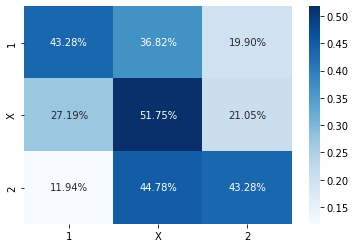

In [69]:
# soronként, azaz az eredeti osztályozás szerint
sns.heatmap(cf_matrix/np.repeat(np.sum(cf_matrix, axis=1), 3).reshape(3, 3), annot=True, fmt='.2%', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])

Tehát a valójában 1-es győzelmet hozó mérkőzést közel 43 százalékban 1-esnek tippeljük mi is. A 2-es esetben ez 43%, döntetlennél: 52%.



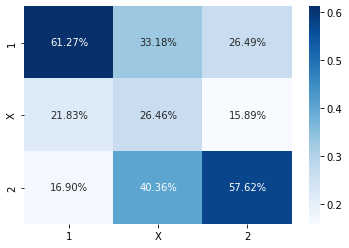

In [70]:
# oszloponként, azaz a predikció szerint
sns.heatmap(cf_matrix/np.repeat([np.sum(cf_matrix, axis=0)], 3, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])

Vagyis amit mi 1-esnek tippeltünk kb. 61 százalékban 1-es lett tényleg. 2-esnél: 58%, X-nél: 26%.

In [71]:
np.sum(np.diagonal(cf_matrix))/np.sum(cf_matrix)

0.45155038759689925

A meccsek eredményeit 45%-kal találjuk el.

Az eredmények kiértékelésénél érdemes figyelembevenni, hogy ez még csak a nullmodellünk, és regression tuning (az osztályózók optimalizásának) segítségével valószínűleg még jobb eredményt érhetnénk el. Erre azonban nem volt időnk, ugyanis az első projektünk a félév több mint felét kitöltötte.
Ezenkívül gondolkodásra érdemes még az a kérdés is, hogy az eredmények tudatában milyen fogadási stratégiát lenne jó használni a modell segítségével. Ez adott esetben vissza is hathat a modell kiértékelésére is, ugyanis pl. lehet, hogy mi a szinte biztos meccsekre nem is szeretnénk fogadni.